# Rodriguez Human MYC data
## Xiaonan Wang
## 23May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [9]:
# Data downloaded from GEO
data = pd.read_csv('GSE157591_UMIcounts.csv', sep='\t',index_col=0)

In [11]:
adata = anndata.AnnData(X=data.T)

In [13]:
adata.var_names = data.index
adata.obs_names = data.columns

In [16]:
adata.shape

(8275, 49456)

In [17]:
adata.obs_names

Index(['AAAGCAATCTTGCAAG-Patient_3', 'AAAGTAGAGGAGCGAG-Patient_3',
       'AAAGTAGAGTCATCCA-Patient_3', 'AAAGTAGCACAACGTT-Patient_3',
       'AACCATGCAATCGGTT-Patient_3', 'AACCATGCATCTCCCA-Patient_3',
       'AACTCAGGTGGTCTCG-Patient_3', 'AACTCTTGTAGCGCAA-Patient_3',
       'AACTCTTGTGAGGGAG-Patient_3', 'AACTTTCGTTCATGGT-Patient_3',
       ...
       'TTGTAGGGTAATCGTC-Patient_7', 'TTTATGCAGACCTTTG-Patient_7',
       'TTTCCTCAGCTAACAA-Patient_7', 'TTTCCTCGTGCTCTTC-Patient_7',
       'TTTGCGCGTGTCCTCT-Patient_7', 'TTTGCGCTCACCCTCA-Patient_7',
       'TTTGGTTAGCAATCTC-Patient_7', 'TTTGGTTCATTGGGCC-Patient_7',
       'TTTGGTTTCAAACGGG-Patient_7', 'TTTGTCACAGTATGCT-Patient_7'],
      dtype='object', length=8275)

In [18]:
adata.obs['plate'] = [x.split('-')[1] for x in adata.obs_names]

In [19]:
adata.obs['plate'].value_counts()

Healthy_5    2654
Healthy_2    1049
Healthy_1     782
Patient_4     680
Healthy_3     650
Patient_7     581
Patient_2     466
Patient_3     465
Healthy_4     457
Patient_5     254
Patient_1     237
Name: plate, dtype: int64

In [20]:
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

In [21]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], inplace=True)

In [22]:
import seaborn as sns

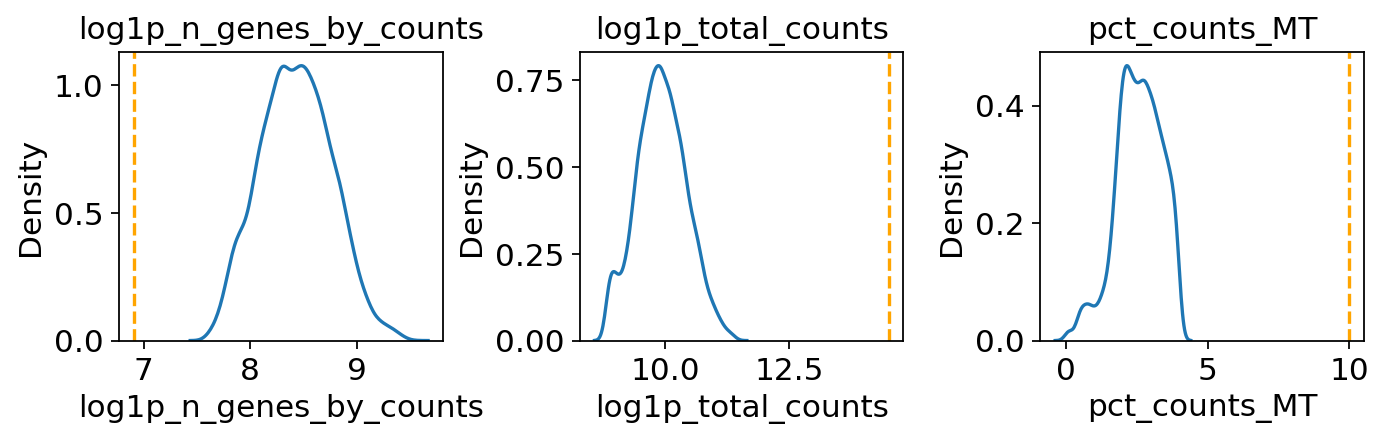

In [23]:
obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_MT']
cutoffs = [1000,2000000, np.exp(10)]
fig,ax = plt.subplots(1,3, figsize=(9,3))
for i in range(len(obs_terms)):
    sns.kdeplot(adata.obs[obs_terms[i]], ax=ax[i])
    ax[i].grid(False)
    ax[i].set_title(obs_terms[i])
    ax[i].axvline(np.log1p(cutoffs[i]), c='orange', linestyle='--')
plt.tight_layout()

In [24]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=1)

filtered out 3 genes that are detected in less than 1 cells


In [25]:
adata.shape

(8275, 49453)

In [26]:
adata.write('./raw_afterQC_all.h5ad')

/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'plate' as categorical


In [28]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [29]:
sc.pp.log1p(adata)

In [30]:
adata.raw = adata

In [31]:
adata.write('./raw_afterQC_all_lognorm.h5ad')

In [32]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.5, batch_key='plate', inplace=True)

extracting highly variable genes
    finished (0:00:16)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


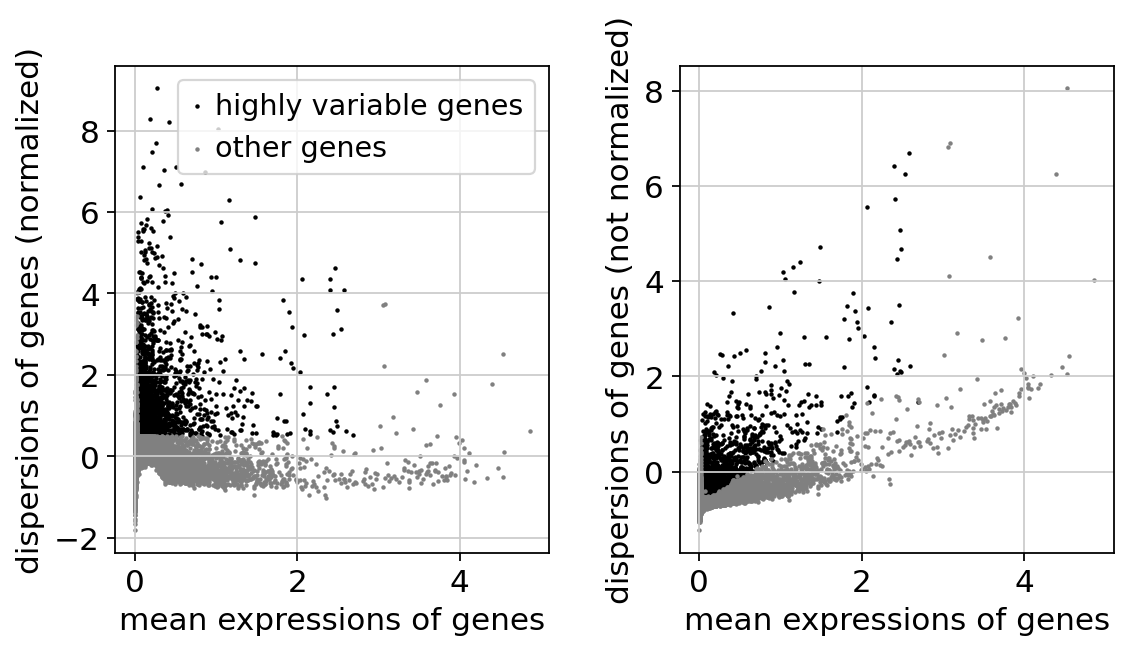

In [33]:
sc.pl.highly_variable_genes(adata)

In [34]:
print(np.sum(adata.var.highly_variable))

2816


In [35]:
adata = adata[:, adata.var.highly_variable].copy()

In [36]:
adata.write('./raw_afterQC_all_lognorm_hvg.h5ad')

In [37]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


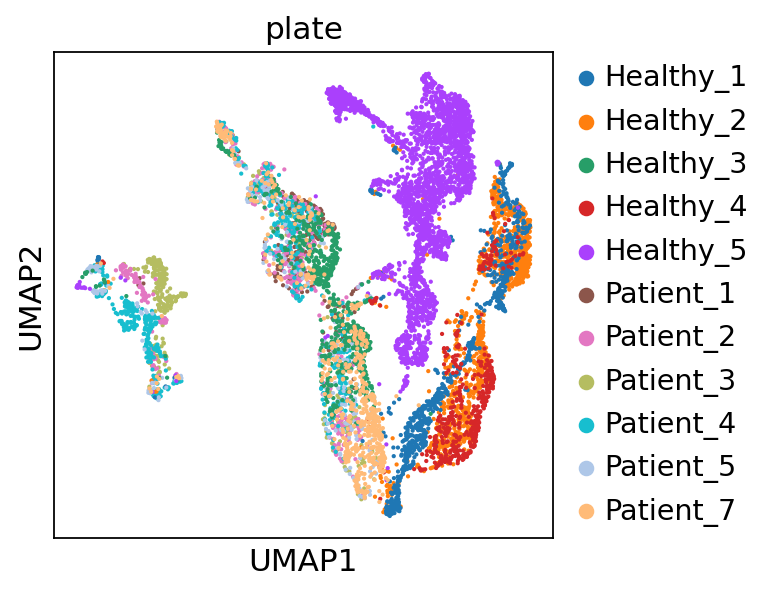

In [38]:
sc.pl.umap(adata, color=['plate'])

In [39]:
adata.write('./raw_afterQC_all_lognorm_hvg_processed.h5ad')

# Try harmony

In [40]:
sc.external.pp.harmony_integrate(adata, key='plate')

2023-01-16 16:32:51,265 - harmonypy - INFO - Iteration 1 of 10
2023-01-16 16:32:52,605 - harmonypy - INFO - Iteration 2 of 10
2023-01-16 16:32:53,922 - harmonypy - INFO - Iteration 3 of 10
2023-01-16 16:32:55,261 - harmonypy - INFO - Iteration 4 of 10
2023-01-16 16:32:56,638 - harmonypy - INFO - Iteration 5 of 10
2023-01-16 16:32:57,814 - harmonypy - INFO - Iteration 6 of 10
2023-01-16 16:32:58,647 - harmonypy - INFO - Iteration 7 of 10
2023-01-16 16:32:59,578 - harmonypy - INFO - Iteration 8 of 10
2023-01-16 16:33:00,475 - harmonypy - INFO - Iteration 9 of 10
2023-01-16 16:33:01,394 - harmonypy - INFO - Iteration 10 of 10
2023-01-16 16:33:02,143 - harmonypy - INFO - Stopped before convergence


In [41]:
'X_pca_harmony' in adata.obsm

True

In [42]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [45]:
adata.obs['Condition'] = [x.split('_')[0] for x in adata.obs['plate']]

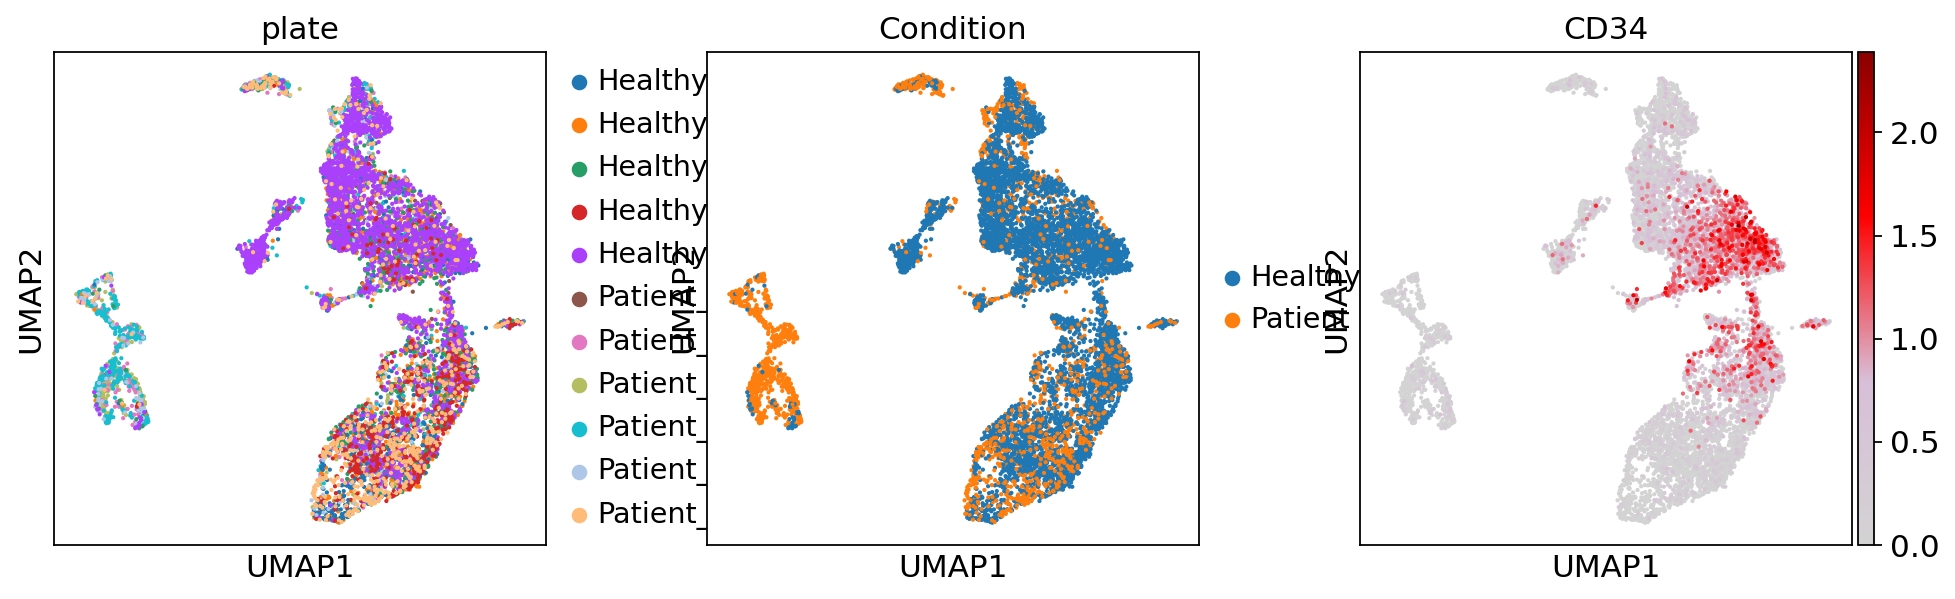

In [48]:
sc.pl.umap(adata, color=['plate', 'Condition', 'CD34'], color_map=cmap)

In [44]:
adata.write('./raw_afterQC_all_lognorm_hvg_processed_harmony.h5ad')